## **Import Library**

In [2]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Tentukan path folder data Anda di Drive
DATA_DIR = '/content/drive/MyDrive/nlp-deepL'

# 2. Instal Pustaka Eksternal
# Sastrawi untuk Stemming Bahasa Indonesia
!pip install Sastrawi

# Pustaka lain yang akan digunakan
import pandas as pd
import numpy as np
import re
import os
import json
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Input, TimeDistributed
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 8.1 MB/s eta 0:00:00


## **muat dan proses data awal**

### muat semua data

In [3]:
# Dictionary untuk menampung semua data yang dimuat
data = {}

print("Memulai proses memuat data...\n")

try:
    # --- 1. MEMUAT DATASET SENTIMEN (FORMAT .CSV) ---
    # pd.read_csv() adalah fungsi standar untuk file .csv
    print("Memuat dataset sentimen...")
    data['sentiment_cyberbullying'] = pd.read_csv(os.path.join(DATA_DIR, 'dataset_komentar_instagram_cyberbullying.csv'))
    data['sentiment_tv'] = pd.read_csv(os.path.join(DATA_DIR, 'dataset_tweet_sentimen_tayangan_tv.csv'))
    data['sentiment_opini_film'] = pd.read_csv(os.path.join(DATA_DIR, 'dataset_tweet_sentiment_opini_film.csv'))
    print(" -> 3 dataset sentimen (csv) berhasil dimuat.")

    # --- 2. MEMUAT DATASET Q&A (FORMAT BERAGAM) ---
    print("\nMemuat dataset Q&A...")
    # .csv biasa
    # data['qna_medical'] = pd.read_csv(os.path.join(DATA_DIR, 'qna-medical.csv'))
    # .parquet, format kolom yang efisien. Gunakan pd.read_parquet()
    data['qna_psychiatrist'] = pd.read_parquet(os.path.join(DATA_DIR, 'qna-psychiatrist.parquet'))
    print(" -> 3 dataset Q&A (csv, jsonl, parquet) berhasil dimuat.")

    # --- 3. MEMUAT FILE TEKS TAMBAHAN (FORMAT .TXT) ---
    # Untuk file .txt, kita baca baris per baris
    print("\nMemuat file teks tambahan...")
    with open(os.path.join(DATA_DIR, 'combined_stop_words.txt'), 'r') as f:
        data['stop_words'] = [line.strip() for line in f.readlines()]

    with open(os.path.join(DATA_DIR, 'combined_slang_words.txt'), 'r') as f:
        # Untuk slang, kita perlu mapping dari slang -> baku. Kita asumsikan formatnya "slang:baku"
        slang_map = {}
        for line in f:
            if ':' in line:
                slang, formal = line.strip().split(':', 1)
                slang_map[slang.strip()] = formal.strip()
        data['slang_words'] = slang_map

    with open(os.path.join(DATA_DIR, 'combined_root_words.txt'), 'r') as f:
        data['root_words'] = [line.strip() for line in f.readlines()]

    with open(os.path.join(DATA_DIR, 'wordlist.txt'), 'r') as f:
        data['wordlist'] = [line.strip() for line in f.readlines()]
    print(" -> 4 file teks (txt) berhasil dimuat.")

    print("\n✅ Semua data berhasil dimuat ke dalam dictionary 'data'!")

except FileNotFoundError as e:
    print(f"\n❌ ERROR: File tidak ditemukan! Pastikan path '{DATA_DIR}' sudah benar dan file ada di dalamnya.")
    print(f"Detail error: {e}")

Memulai proses memuat data...

Memuat dataset sentimen...
 -> 3 dataset sentimen (csv) berhasil dimuat.

Memuat dataset Q&A...
 -> 3 dataset Q&A (csv, jsonl, parquet) berhasil dimuat.

Memuat file teks tambahan...
 -> 4 file teks (txt) berhasil dimuat.

✅ Semua data berhasil dimuat ke dalam dictionary 'data'!


In [33]:
# Dataset Medis (dari CSV)
print("--- Q&A Medis ---")
display(data['qna_medical'].head())

# Dataset Psikiater (dari Parquet)
print("\n--- Q&A Psikiater ---")
display(data['qna_psychiatrist'].head())

--- Q&A Medis ---


,question,answer
0,Pandangan mata saya udah sebulan ini jika meli...,"Alo, terimakasih atas pertanyaannya. Muncul b..."
1,"Hi dokter, dok saya ada gangguan di mata saya....","Selamat siang, terima kasih telah bertanya di ..."
2,Alo dokter... Saya ingin bertanya tentang sara...,"Alo, terimakasih atas pertanyaannya. Kecelaka..."
3,"Selamat malam dok, saya mau bertanya apakah ab...",Terima kasih atas pertanyaannya. Ablasio retin...
4,mohon maaf dok mau tanya bisa tolong jelaskan ...,"Alo, terima kasih ya sudah bertanya di Alodokt..."



--- Q&A Psikiater ---


,question,answer
0,"Dok, gue kayaknya stres banget nih gara-gara t...","Oke, ceritain dulu apa yang bikin kamu merasa ..."
1,"Gue bingung banget, tugas-tugas ini nggak ada ...","Hmm, kamu coba udah bikin jadwal atau planning..."
2,"Iya, udah sih, tapi tetep aja kayak nggak cuku...",Mungkin kamu bisa coba bagi waktu lebih detail...
3,"Masalahnya, gue juga punya kegiatan organisasi...","Oh, kamu aktif di organisasi juga ya. Berarti ..."
4,"Iya, bener banget. Kadang gue ngerasa nggak bi...",Pernah coba delegasiin tugas organisasi ke ang...


In [8]:
# Memilih dan mengganti nama kolom
data['qna_medical'] = data['qna_medical'][['question_clean', 'answer_clean']].rename(
    columns={'question_clean': 'question', 'answer_clean': 'answer'}
)
print(f" -> Berhasil memuat {len(data['qna_medical'])} data medis.")

 -> Berhasil memuat 681203 data medis.


In [9]:
display(data['qna_medical'].head())

,question,answer
0,Pandangan mata saya udah sebulan ini jika meli...,"Alo, terimakasih atas pertanyaannya. Muncul b..."
1,"Hi dokter, dok saya ada gangguan di mata saya....","Selamat siang, terima kasih telah bertanya di ..."
2,Alo dokter... Saya ingin bertanya tentang sara...,"Alo, terimakasih atas pertanyaannya. Kecelaka..."
3,"Selamat malam dok, saya mau bertanya apakah ab...",Terima kasih atas pertanyaannya. Ablasio retin...
4,mohon maaf dok mau tanya bisa tolong jelaskan ...,"Alo, terima kasih ya sudah bertanya di Alodokt..."


In [34]:
# Mengganti nama kolom
data['qna_psychiatrist'] = data['qna_psychiatrist'].rename(
    columns={'User': 'question', 'Psikiater': 'answer'}
)
print(f" -> Berhasil memuat {len(data['qna_psychiatrist'])} data psikiater.")

 -> Berhasil memuat 6477 data psikiater.


In [13]:
display(data['qna_psychiatrist'].head())

,question,answer
0,"Dok, gue kayaknya stres banget nih gara-gara t...","Oke, ceritain dulu apa yang bikin kamu merasa ..."
1,"Gue bingung banget, tugas-tugas ini nggak ada ...","Hmm, kamu coba udah bikin jadwal atau planning..."
2,"Iya, udah sih, tapi tetep aja kayak nggak cuku...",Mungkin kamu bisa coba bagi waktu lebih detail...
3,"Masalahnya, gue juga punya kegiatan organisasi...","Oh, kamu aktif di organisasi juga ya. Berarti ..."
4,"Iya, bener banget. Kadang gue ngerasa nggak bi...",Pernah coba delegasiin tugas organisasi ke ang...


#### gabung dua dataset

In [36]:
## -- PENGAMBILAN SAMPEL STRATEGIS (Total 50,000 Data) --

# 1. Menambahkan kolom 'sumber' ke setiap DataFrame
data['qna_medical']['sumber'] = 'medis'
data['qna_psychiatrist']['sumber'] = 'psikiater'

# 2. Menentukan ukuran sampel
total_sample_size = 50000
sample_psikiater = data['qna_psychiatrist']

# 3. Menghitung sisa sampel yang akan diambil dari data medis
remaining_size = total_sample_size - len(sample_psikiater)

print(f"Mengambil semua {len(sample_psikiater)} data Psikiater.")
print(f"Mengambil {remaining_size} sampel acak dari data Medis.")

# 4. Mengambil sampel acak dari data medis
sample_medis = data['qna_medical'].sample(n=remaining_size, random_state=42)

# 5. Menggabungkan kedua sampel menjadi satu DataFrame
df_qna_sampled = pd.concat([sample_medis, sample_psikiater], ignore_index=True)

# 6. Mengacak urutan DataFrame akhir agar data tidak mengelompok
df_qna_sampled = df_qna_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n✅ Proses selesai! Dataset Q&A sampel berhasil dibuat.")
print(f"Total data gabungan: {len(df_qna_sampled)} baris.")

print("\nDistribusi data dalam sampel:")
print(df_qna_sampled['sumber'].value_counts())

# Tampilkan sampel dari data gabungan akhir
print("\nSampel dari dataset Q&A gabungan:")
display(df_qna_sampled.sample(10))

# Ganti df_qna_combined lama dengan yang baru agar sisa kode tetap berjalan
df_qna_combined = df_qna_sampled

Mengambil semua 6477 data Psikiater.
Mengambil 43523 sampel acak dari data Medis.

✅ Proses selesai! Dataset Q&A sampel berhasil dibuat.
Total data gabungan: 50000 baris.

Distribusi data dalam sampel:
sumber
medis        43523
psikiater     6477
Name: count, dtype: int64

Sampel dari dataset Q&A gabungan:


,question,answer,sumber
45386,"Selamat Pagi Dok, Saya sudah 2 minggu ini buan...","Alo Dwirizkin, terima kasih ya sudah bertanya ...",medis
24958,Dok saya berusia 29 thun ingin menambah momong...,Halo. Terima kasih atas pertanyaan yang disamp...,medis
49652,Slamat pagi dokter..nanya lg nich..knapa ea do...,Hai Evalina Kehamilan terjadi akibat pertemua...,medis
17973,"Selamat pagi dok.\r Saya mau tanya, kelopak ma...",Halo alinsafalin...... Terimakasih atas pertan...,medis
44302,Selamat pagi dokter...\r Saat ini saya sedang ...,"Hai, Demam disertai penurunan trombosit biasan...",medis
9,"Siang dok.. sy mau nanya dok. sy 37 th, penggu...","Hai Iim, Menstruasi merupakan siklus alami pad...",medis
21260,"Mudah-mudahan dengan perubahan ini, gue bisa l...","Pasti bisa! Perlahan tapi pasti, lo akan melih...",psikiater
11609,Dok perut saya terasa aneh setelah saya pencet...,"Halo Putri, terima kasih telah bertanya di Alo...",medis
28519,"dok saya mau tanya , saya hamil 38weeks mata s...",Hai bunda Ria. Terima kasih atas pertanyaan an...,medis
39002,".dok, saya kan punya luka yang harus dijahit d...","Halo, Terimakasih atas pertanyaan yang diajuk...",medis


### Load data lainnya (slang word, stop word list)

In [45]:
import json

# Definisikan kembali path utama
DATA_DIR = '/content/drive/MyDrive/nlp-deepL'

# Muat ulang slang_map menggunakan library json
try:
    with open(os.path.join(DATA_DIR, 'combined_slang_words.txt'), 'r') as f:
        slang_map = json.load(f)
    print("✅ Kamus slang berhasil dimuat ulang dengan benar!")
    print(f"Jumlah slang words: {len(slang_map)}")

    # Verifikasi dengan melihat beberapa contoh
    contoh_slang_benar = {k: slang_map[k] for k in list(slang_map)[:5]}
    print(f"Contoh slang words: {contoh_slang_benar}")

except json.JSONDecodeError:
    print("❌ Gagal memuat file slang. File tersebut bukan format JSON yang valid.")
except Exception as e:
    print(f"❌ Terjadi error: {e}")

# Pastikan variabel 'data' juga diperbarui jika Anda menggunakannya di tempat lain
data['slang_words'] = slang_map

✅ Kamus slang berhasil dimuat ulang dengan benar!
Jumlah slang words: 1018
Contoh slang words: {'@': 'di', 'abis': 'habis', 'ad': 'ada', 'adlh': 'adalah', 'afaik': 'as far as i know'}


In [46]:
print(f"Jumlah stop words: {len(data['stop_words'])}")
print(f"Contoh stop words: {data['stop_words'][:10]}")

print(f"\nJumlah slang words: {len(data['slang_words'])}")
# Mengambil 5 item pertama dari dictionary slang
contoh_slang = {k: data['slang_words'][k] for k in list(data['slang_words'])[:5]}
print(f"Contoh slang words: {contoh_slang}")

print(f"\nJumlah kata di wordlist KBBI: {len(data['wordlist'])}")
print(f"Contoh kata: {data['wordlist'][1000:1010]}")

Jumlah stop words: 675
Contoh stop words: ['adalah', 'adapun', 'agaknya', 'akan', 'akhir', 'akhirnya', 'akulah', 'amatlah', 'andalah', 'antara']

Jumlah slang words: 1018
Contoh slang words: {'@': 'di', 'abis': 'habis', 'ad': 'ada', 'adlh': 'adalah', 'afaik': 'as far as i know'}

Jumlah kata di wordlist KBBI: 105225
Contoh kata: ['aglaonema', 'aglet', 'aglikon', 'agliofobia', 'aglomerasi', 'aglomerat', 'aglutinasi', 'aglutinat', 'aglutinatif', 'aglutinin']


## **praprocess**

- Case Folding & Cleaning
- Normalisasi
- Stopword Removal
- Stemming

### persiapan tools

In [4]:
# Instal tqdm untuk melihat progress bar (sangat berguna untuk proses yang lama)
!pip install tqdm
from tqdm import tqdm
tqdm.pandas()

In [5]:
# Buat sebuah dictionary (cache) untuk menyimpan hasil stemming
stem_cache = {}
# Juga buat cache untuk seluruh proses
preprocess_cache = {}

factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(data['stop_words'])
slang_map = data['slang_words']


def preprocess_text_cached(text):
    if not isinstance(text, str):
        return ""

    # Cek apakah seluruh teks sudah pernah diproses
    if text in preprocess_cache:
        return preprocess_cache[text]

    # 1. & 2. Case Folding & Cleaning (proses ini cepat, tidak perlu cache)
    processed_text = text.lower()
    processed_text = re.sub(r'http\S+|www\S+|https\S+', '', processed_text, flags=re.MULTILINE)
    processed_text = re.sub(r'\@\w+|\#\w+', '', processed_text)
    processed_text = re.sub(r'\d+', '', processed_text)
    processed_text = re.sub(r'[^a-zA-Z\s]', '', processed_text)
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()

    # 3. & 4. Normalisasi & Stopword Removal (juga relatif cepat)
    words = processed_text.split()
    normalized_words = [slang_map[word] if word in slang_map else word for word in words]
    filtered_words = [word for word in normalized_words if word not in stop_words]

    # 5. Stemming dengan Cache
    stemmed_words = []
    for word in filtered_words:
        if word in stem_cache:
            stemmed_words.append(stem_cache[word])
        else:
            stemmed_word = stemmer.stem(word)
            stem_cache[word] = stemmed_word
            stemmed_words.append(stemmed_word)

    final_text = ' '.join(stemmed_words)

    # Simpan hasil akhir ke cache utama
    preprocess_cache[text] = final_text

    return final_text

### terapkan pada dataframe

In [37]:
df_qna_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  49996 non-null  object
 1   answer    50000 non-null  object
 2   sumber    50000 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [40]:
print("Memulai preprocessing pada data Q&A (chatbot)...")

df_qna_cleaned = df_qna_combined

# Lakukan preprocessing hanya pada sampel ini
df_qna_cleaned['question_clean'] = df_qna_cleaned['question'].progress_apply(preprocess_text_cached)
df_qna_cleaned['answer_clean'] = df_qna_cleaned['answer'].progress_apply(preprocess_text_cached)

print("\n Preprocessing data Q&A selesai.")
print("Berikut perbandingan teks asli dan teks bersih untuk Q&A:")

# Tampilkan kolom asli dan kolom yang sudah bersih untuk perbandingan
display(df_qna_cleaned[['question', 'question_clean', 'answer', 'answer_clean']].sample(10))

Memulai preprocessing pada data Q&A (chatbot)...


100%|██████████| 50000/50000 [2:53:25<00:00,  4.81it/s]



 Preprocessing data Q&A selesai.
Berikut perbandingan teks asli dan teks bersih untuk Q&A:


,question,question_clean,answer,answer_clean
37734,Sy wanita berusia 25 tahun. Kadang ketika bany...,sy wanita usia kadang pikir da tugas hitung hi...,"Selamat sore Astini, Stress dapat membawa damp...",selamat sore astini stress dampak positif pacu...
38851,"Alodokter, anak saya usia 4 tahun sulit makan....",alodokter anak usia sulit makan kasih makan to...,"Alo, Vitamin C banyak ditemukan dalam buah dan...",alo vitamin c dalam buah sayur vitamin c manfa...
37782,"Selamat malam dok, saya perempuan usia 16 tahu...",selamat malam dok perempuan usia rasa kepala t...,Halo brncmra......... Terimakasih atas pertany...,halo brncmra terimakasih ganggu sehat alami ke...
48216,"Makasih dok, gue bakal coba saran-sarannya.",makasih dok gue coba saransarannya,Sama-sama. Jangan ragu buat konsultasi lagi ka...,samasama ragu konsultasi kalo
46196,"Dok saya mau tanya, di dalam testis kiri saya ...",dok dalam testis kiri benjol lendir sakit nyer...,Selamat malam. Terimakasih sudah bertanya ke a...,selamat malam terimakasih alodokter benjol dal...
12441,Di paling ujung ada keluar benang. Tapi benang...,ujung keluar benang benang keras dok kayu warn...,"Halo, terimakasih atas pertanyaannya untuk Ald...",halo terimakasih tanya aldookter pertamatama t...
32071,"Belum, gue takut dia marah.",gue takut marah,"Wajar sih, tapi kadang-kadang penting buat bil...",wajar sih kadangkadang bilang coba
21051,dok jari tengah saya seperti kebas mati rasa a...,dok jari kebas mati akibat gunting darah dalam...,"Alo, terimakasih atas pertanyaannya. Jari yan...",alo terimakasih tanya jari gunting picu ganggu...
16343,"Selamat malam Dok,..Anak saya balita umur 9 bu...",selamat malam dokanak balita umur derita gatal...,"Alo Joko, terima kasih ya sudah bertanya di Al...",alo joko terima kasih alodokter biang keringat...
44006,"Malam dok, umur saya 38 tahun, saya ingin bert...",malam dok umur nyeri lutut paha pinggul panggu...,"Alo Sri, Terimakasih atas pertanyaannya. Saat...",alo sri terimakasih tanya hubung seksual gantu...


### simpan data

In [78]:
# Gabungkan path folder dengan nama file untuk membuat path lengkap
save_path_qna = os.path.join(DATA_DIR, 'qna_50k_clean.feather')
save_path_sentiment = os.path.join(DATA_DIR, 'sentiment_clean.feather')

# Simpan file ke path yang sudah ditentukan di Google Drive
df_qna_combined.to_feather(save_path_qna)
df_sentiment_combined.to_feather(save_path_sentiment)

print(f"File Q&A berhasil disimpan di: {save_path_qna}")
print(f"File Sentimen berhasil disimpan di: {save_path_sentiment}")

File Q&A berhasil disimpan di: /content/drive/MyDrive/nlp-deepL/qna_50k_clean.feather
File Sentimen berhasil disimpan di: /content/drive/MyDrive/nlp-deepL/sentiment_clean.feather


## **Tokenisasi & padding**

### muat data cleaned

In [7]:
# Langsung jalankan blok ini untuk memuat hasil kerja Anda
df_qna_combined = pd.read_feather('/content/drive/MyDrive/nlp-deepL/qna_50k_clean.feather')
df_sentiment_combined = pd.read_feather('/content/drive/MyDrive/nlp-deepL/sentiment_clean.feather')
print("✅ Data bersih berhasil dimuat kembali!")

✅ Data bersih berhasil dimuat kembali!


In [8]:
display(df_qna_combined.head())
display(df_sentiment_combined.head())

,question,answer,sumber,question_clean,answer_clean,answer_processed
0,"Malam dok, awalnya saya merasa tidak merasakan...","Alo, terima kasih sudah bertanya kepada Alodok...",medis,malam dok rasa apaapa tibatiba tubuh hilang im...,alo terima kasih alodokter erti khawatir keluh...,<start> alo terima kasih alodokter erti khawat...
1,"Alo Dok, bagaimana untuk bisa mengetahui kalau...",Terima kasih atas pertanyaannya. Infeksi pada ...,medis,alo dok kena helicobacter pylori obat periksa ...,terima kasih tanya infeksi lambung sebab bakte...,<start> terima kasih tanya infeksi lambung seb...
2,"Selamat siang dok, saya memiliki bayi berusia ...","Alo Jantia, Terimakasih atas pertanyaannya. B...",medis,selamat siang dok milik bayi usia bayi alami b...,alo jantia terimakasih tanya bruntusan serta m...,<start> alo jantia terimakasih tanya bruntusan...
3,"Siang Dok, maaf tanya\r 1. Apakah hidrokel pad...",Halo Aji Hidrokel berbeda dengan hernia. Hidr...,medis,siang dok maaf hidrokel dewasa th bahaya rasa ...,halo aji hidrokel beda hernia hidrokel tumpu c...,<start> halo aji hidrokel beda hernia hidrokel...
4,dok saya mau tanya tentang dampak dan gejala a...,"Alo Glourythaa Lekatompessy, terimakasih sudah...",medis,dok dampak gejala kepala injak bagi kepala rak...,alo glourythaa lekatompessy terimakasih alodok...,<start> alo glourythaa lekatompessy terimakasi...


,text,sentiment,text_clean
0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,negative,username tolol gak nya gugur dgn pake hijab sy...
1,Geblek lo tata...cowo bgt dibela2in balikan......,negative,geblek tatacowo bgt bain balikanhadewwntar tin...
2,Kmrn termewek2 skr lengket lg duhhh kok labil ...,negative,kmrn mewek skr lengket lg duhhh labil bgt sih ...
3,"Intinya kalau kesel dengan ATT nya, gausah ke ...",negative,inti kesel att nya gausah anak kasi kembang ps...
4,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",negative,hade permpuan lgsakit jiwaknp jd peran utama f...


### Tokenisasi


Membuat Kamus: Kita kumpulkan semua kata unik dari seluruh data pertanyaan dan jawaban.

Memberi Nomor ID: Setiap kata diberi nomor ID unik. batasi kamus hanya untuk 15.000 kata yang paling sering muncul (vocab_size_qna).

Menangani Kata Asing: Kata yang tidak ada di dalam kamus 15.000 kata tersebut akan diganti dengan token khusus <OOV> (Out-of-Vocabulary).

In [9]:
# --- 1. MEMPERSIAPKAN DATA CHATBOT ---

# Tambahkan token <start> dan <end> pada setiap jawaban
df_qna_combined['answer_processed'] = df_qna_combined['answer_clean'].apply(lambda x: '<start> ' + str(x) + ' <end>')

# Ambil data pertanyaan dan jawaban yang sudah bersih/diproses
questions = df_qna_combined['question_clean'].astype(str).values
answers = df_qna_combined['answer_processed'].astype(str).values

In [10]:
# --- 2. TOKENISASI TEKS ---

# Buat SATU tokenizer untuk pertanyaan dan jawaban agar kamusnya sama
vocab_size_qna = 15000
oov_token = "<OOV>"

# Inisialisasi dan fit tokenizer pada SEMUA teks (pertanyaan + jawaban)
tokenizer_qna = Tokenizer(num_words=vocab_size_qna, oov_token=oov_token, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer_qna.fit_on_texts(np.append(questions, answers))

# Ubah pertanyaan menjadi sequences
question_sequences = tokenizer_qna.texts_to_sequences(questions)

# Ubah jawaban menjadi sequences
answer_sequences = tokenizer_qna.texts_to_sequences(answers)

### Padding

Menyamakan Panjang Semua Kalimat.

menetapkan panjang kalimat maksimal (maxlen), misalnya 50 kata.
Kalimat yang lebih pendek dari 50 akan ditambahkan angka 0 di belakangnya hingga panjangnya mencapai 50.
Kalimat yang lebih panjang dari 50 akan dipotong.

In [11]:
# --- 3. PADDING SEQUENCES ---

maxlen_question = 50
maxlen_answer = 50

# Lakukan padding pada pertanyaan
encoder_input_data = pad_sequences(question_sequences, maxlen=maxlen_question, padding='post', truncating='post')

# Lakukan padding pada jawaban
decoder_input_data = pad_sequences(answer_sequences, maxlen=maxlen_answer, padding='post', truncating='post')

In [12]:
# --- 4. MEMPERSIAPKAN TARGET UNTUK DECODER ---

# Target decoder adalah sekuens jawaban yang di-shift satu langkah ke depan
# (model harus memprediksi kata selanjutnya)
# Contoh: <start> halo apa kabar <end>
# Input decoder: [<start>, halo, apa, kabar]
# Target decoder: [halo, apa, kabar, <end>]

decoder_target_data = np.zeros_like(decoder_input_data)
for i, seq in enumerate(decoder_input_data):
    decoder_target_data[i, :-1] = seq[1:]

In [13]:
import pickle
import os

# Pastikan DATA_DIR sudah didefinisikan
# DATA_DIR = '/content/drive/MyDrive/nlp-deepL'

# Tentukan path penyimpanan untuk tokenizer
tokenizer_path = os.path.join(DATA_DIR, 'tokenizer_chatbot.pickle')

# Simpan tokenizer menggunakan pickle
with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer_qna, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"✅ Tokenizer berhasil disimpan di: {tokenizer_path}")

✅ Tokenizer berhasil disimpan di: /content/drive/MyDrive/nlp-deepL/tokenizer_chatbot.pickle


#### split data

In [10]:
# --- 5. MEMBAGI DATA (SPLIT) ---

# Bagi data menjadi data latih (training) dan data uji (testing)
X_train_qna, X_test_qna, y_train_qna, y_test_qna = train_test_split(
    encoder_input_data,       # Input: Pertanyaan
    decoder_input_data,       # Input Decoder: Jawaban dengan <start>
    test_size=0.2, random_state=42
)

# Bagi juga data target decoder
y_train_target_qna, y_test_target_qna = train_test_split(
    decoder_target_data,      # Target Decoder: Jawaban yang di-shift
    test_size=0.2, random_state=42
)


print("✅ Data untuk Chatbot SIAP!")
print(f"Bentuk Encoder Input Data (Pertanyaan): {encoder_input_data.shape}")
print(f"Bentuk Decoder Input Data (Input Jawaban): {decoder_input_data.shape}")
print(f"Bentuk Decoder Target Data (Target Jawaban): {decoder_target_data.shape}")

✅ Data untuk Chatbot SIAP!
Bentuk Encoder Input Data (Pertanyaan): (50000, 50)
Bentuk Decoder Input Data (Input Jawaban): (50000, 50)
Bentuk Decoder Target Data (Target Jawaban): (50000, 50)


## **Training Model**

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

### Definisi semua model

In [64]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np

# --- Parameter Umum ---
embedding_dim = 128         # Ukuran embedding lebih besar untuk tugas yg lebih kompleks
latent_dim_base = 128       # Ukuran 'vektor pikiran' untuk baseline
vocab_size_qna = 15000      # Pastikan ini sama dengan saat tokenisasi
maxlen_question = 50        # Pastikan ini sama dengan saat padding
maxlen_answer = 50          # Pastikan ini sama dengan saat padding

# --- Fungsi Bantuan untuk Membuat Model ---
# Ini untuk menghindari pengulangan kode

def create_seq2seq_model(rnn_layer, latent_dim):
    # --- Encoder ---
    encoder_inputs = Input(shape=(maxlen_question,))
    encoder_embedding = Embedding(input_dim=vocab_size_qna, output_dim=embedding_dim)(encoder_inputs)

    # Perbedaan RNN vs LSTM: LSTM punya 2 state (h, c), RNN hanya 1 (h)
    if rnn_layer.__name__ == 'LSTM':
        encoder, state_h, state_c = rnn_layer(latent_dim, return_state=True)(encoder_embedding)
        encoder_states = [state_h, state_c]
    else: # SimpleRNN
        encoder, state_h = rnn_layer(latent_dim, return_state=True)(encoder_embedding)
        encoder_states = [state_h]

    # --- Decoder ---
    decoder_inputs = Input(shape=(maxlen_answer,))
    decoder_embedding_layer = Embedding(input_dim=vocab_size_qna, output_dim=embedding_dim)
    decoder_embedding = decoder_embedding_layer(decoder_inputs)

    decoder_rnn = rnn_layer(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, *__ = decoder_rnn(decoder_embedding, initial_state=encoder_states)

    decoder_dense = Dense(vocab_size_qna, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# --- Membuat 4 Model Berbeda ---

# 1. LSTM Baseline
model_lstm_chatbot_base = create_seq2seq_model(LSTM, latent_dim_base)
print("Model 1: LSTM Baseline (128 units) Dibuat.")

# 2. SimpleRNN Baseline
model_rnn_chatbot_base = create_seq2seq_model(SimpleRNN, latent_dim_base)
print("Model 2: SimpleRNN Baseline (128 units) Dibuat.")

# 3. LSTM High Capacity
model_lstm_chatbot_high = create_seq2seq_model(LSTM, 256) # latent_dim = 256
print("Model 3: LSTM High Capacity (256 units) Dibuat.")

# 4. Stacked LSTM (Dibuat secara manual karena lebih kompleks)
encoder_inputs = Input(shape=(maxlen_question,))
encoder_embedding = Embedding(input_dim=vocab_size_qna, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm1 = LSTM(latent_dim_base, return_sequences=True, return_state=True)
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)
encoder_lstm2 = LSTM(latent_dim_base, return_state=True)
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)
encoder_states = [state_h2, state_c2]

decoder_inputs = Input(shape=(maxlen_answer,))
decoder_embedding_layer = Embedding(input_dim=vocab_size_qna, output_dim=embedding_dim)
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_lstm1 = LSTM(latent_dim_base, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm1(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_qna, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model_lstm_chatbot_stacked = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_lstm_chatbot_stacked.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Model 4: Stacked LSTM Dibuat.")

Model 1: LSTM Baseline (128 units) Dibuat.
Model 2: SimpleRNN Baseline (128 units) Dibuat.
Model 3: LSTM High Capacity (256 units) Dibuat.
Model 4: Stacked LSTM Dibuat.


### Train semua model

In [ ]:
# --- Parameter Training ---
num_epochs = 30 # Seq2Seq butuh lebih banyak epoch
batch_size = 64   # Batch size lebih kecil seringkali lebih baik untuk Seq2Seq
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Dictionary untuk menyimpan history
histories_chatbot = {}

# --- Latih Model 1: LSTM Baseline ---
print("\n--- Melatih Model 1: LSTM Baseline ---")
histories_chatbot['LSTM Baseline'] = model_lstm_chatbot_base.fit(
    [X_train_qna, y_train_qna], y_train_target_qna,
    epochs=num_epochs, batch_size=batch_size, validation_split=0.2,
    callbacks=[early_stopping], verbose=1
)

# --- Latih Model 2: SimpleRNN Baseline ---
print("\n--- Melatih Model 2: SimpleRNN Baseline ---")
histories_chatbot['SimpleRNN Baseline'] = model_rnn_chatbot_base.fit(
    [X_train_qna, y_train_qna], y_train_target_qna,
    epochs=num_epochs, batch_size=batch_size, validation_split=0.2,
    callbacks=[early_stopping], verbose=1
)

# --- Latih Model 3: LSTM High Capacity ---
print("\n--- Melatih Model 3: LSTM High Capacity ---")
histories_chatbot['LSTM High Capacity'] = model_lstm_chatbot_high.fit(
    [X_train_qna, y_train_qna], y_train_target_qna,
    epochs=num_epochs, batch_size=batch_size, validation_split=0.2,
    callbacks=[early_stopping], verbose=1
)

# --- Latih Model 4: Stacked LSTM ---
print("\n--- Melatih Model 4: Stacked LSTM ---")
histories_chatbot['LSTM Stacked'] = model_lstm_chatbot_stacked.fit(
    [X_train_qna, y_train_qna], y_train_target_qna,
    epochs=num_epochs, batch_size=batch_size, validation_split=0.2,
    callbacks=[early_stopping], verbose=1
)

print("\n✅ Semua model chatbot telah selesai dilatih!")

### Evaluate

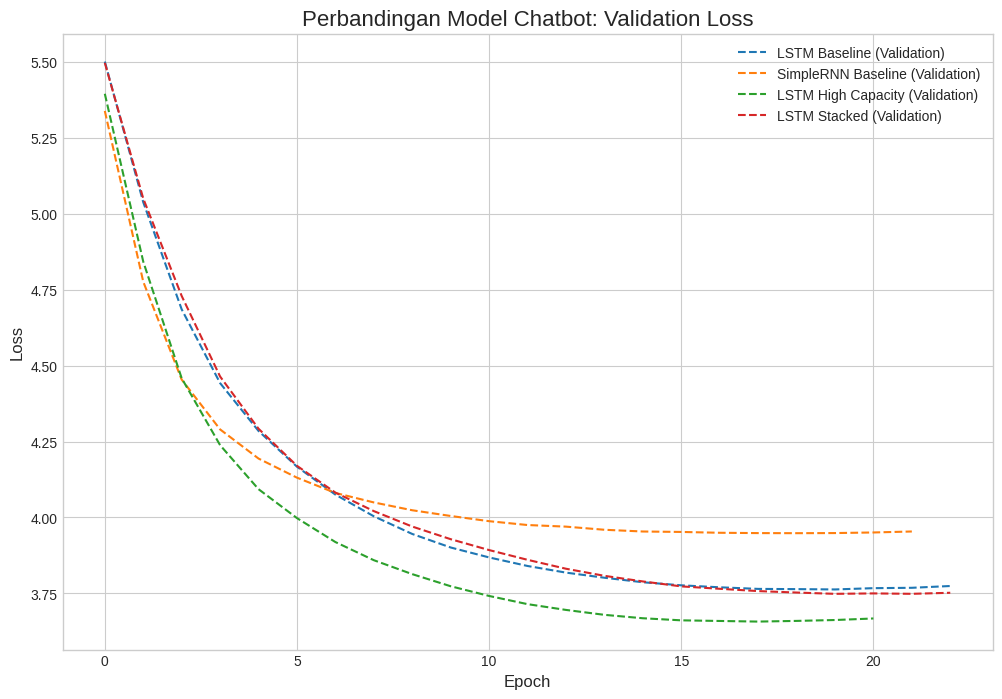

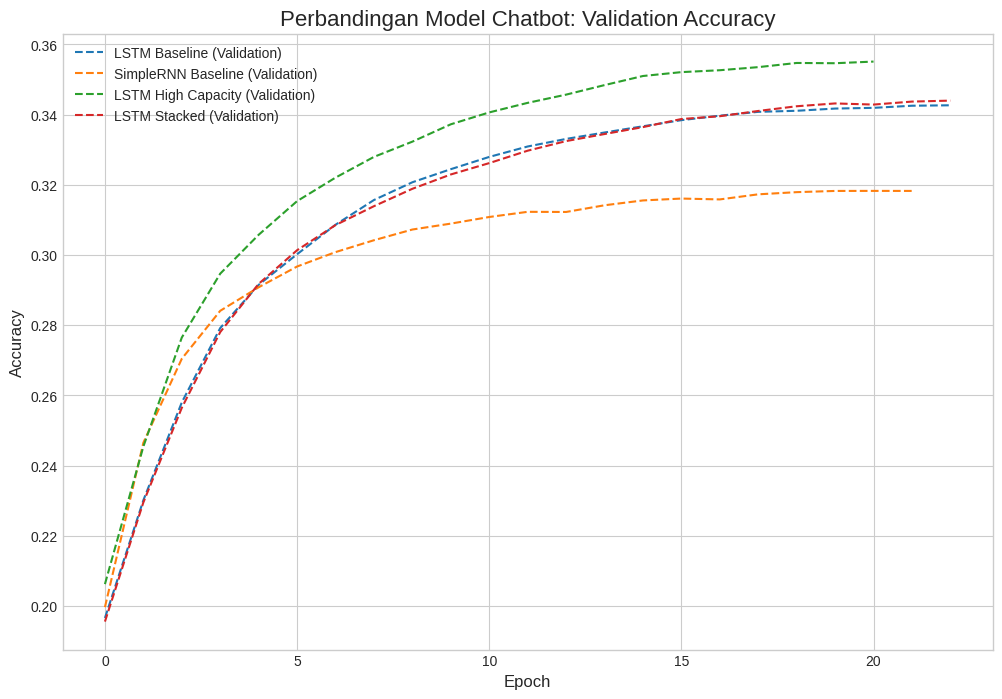

In [26]:
import matplotlib.pyplot as plt

def plot_chatbot_comparison(histories, metric='loss'):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))

    for name, history in histories.items():
        val_metric = 'val_' + metric
        plt.plot(history.history[val_metric], label=f'{name} (Validation)', linestyle='--')

    plt.title(f'Perbandingan Model Chatbot: Validation {metric.capitalize()}', fontsize=16)
    plt.ylabel(metric.capitalize(), fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Buat plot untuk Loss (lebih informatif untuk Seq2Seq)
plot_chatbot_comparison(histories_chatbot, 'loss')

# Buat plot untuk Akurasi
plot_chatbot_comparison(histories_chatbot, 'accuracy')

In [119]:
model_terbaik = model_lstm_chatbot_high

# Tentukan path lengkap beserta nama file di Google Drive
save_path = os.path.join(DATA_DIR, 'chatbot_LSTM_best.keras')

# Simpan model
model_terbaik.save(save_path)

print(f"✅ Model terbaik berhasil disimpan di: {save_path}")

✅ Model terbaik berhasil disimpan di: /content/drive/MyDrive/nlp-deepL/chatbot_LSTM_best.keras


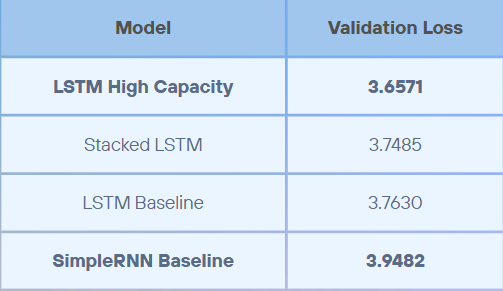

Model LSTM secara konsisten mencapai val_loss yang lebih rendah, membuktikan ia lebih baik dalam memprediksi jawaban.

Mengapa? Arsitektur gate pada LSTM memungkinkannya mengatasi masalah vanishing gradient. Ini membantunya "mengingat" informasi penting dari awal kalimat pertanyaan, tidak seperti SimpleRNN yang cenderung "lupa".

In [118]:
test_loss, test_acc = model_lstm_chatbot_high.evaluate([X_test_qna, y_test_qna], y_test_target_qna)
print(f"Final Test Loss: {test_loss}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.3462 - loss: 3.7187
Final Test Loss: 3.706681966781616


LSTM High Capacity mendapatkan nilai metrik terbaik dari 3 model lainnya

## **evaluasi**

### Evaluasi Kualitatif model chatbot

#### fungsi generate respon

definisikan fungsi untuk membuat respon dari question inputan menggunakan model yang sudah di-train

In [35]:
# Buat dictionary untuk memetakan indeks kembali ke kata
reverse_word_index = {v: k for k, v in tokenizer_qna.word_index.items()}

def generate_response(input_text, model):
    # 1. Pra-proses teks input sama seperti data training
    clean_text = preprocess_text_cached(input_text) # Gunakan fungsi preprocess yg sudah ada

    # 2. Ubah teks menjadi sekuens angka
    input_seq = tokenizer_qna.texts_to_sequences([clean_text])

    # 3. Lakukan padding
    encoder_input = pad_sequences(input_seq, maxlen=maxlen_question, padding='post', truncating='post')

    # 4. Siapkan input awal untuk decoder (<start> token)
    # Ambil indeks dari token '<start>'
    start_token_index = tokenizer_qna.word_index.get('<start>', 1)
    decoder_input = np.zeros((1, maxlen_answer))
    decoder_input[0, 0] = start_token_index

    # 5. Loop untuk menghasilkan jawaban kata per kata
    generated_sentence = []
    for i in range(1, maxlen_answer):
        # Prediksi kata berikutnya
        predictions = model.predict([encoder_input, decoder_input], verbose=0)

        # Ambil kata dengan probabilitas tertinggi (greedy search)
        predicted_id = np.argmax(predictions[0, i-1, :])

        # Jika prediksi adalah token <end> atau 0 (padding), hentikan
        if predicted_id == tokenizer_qna.word_index.get('<end>', 2) or predicted_id == 0:
            break

        # Ubah ID kembali menjadi kata
        word = reverse_word_index.get(predicted_id, '<UNK>')
        generated_sentence.append(word)

        # Update input decoder untuk iterasi berikutnya
        decoder_input[0, i] = predicted_id

    return ' '.join(generated_sentence)

#### perbandingan respon model terbaik dengan model pembanding (RNN)

In [ ]:
# Pilih model terbaik dan model pembanding
model_terbaik = models_chatbot['LSTM High Capacity']
model_pembanding = models_chatbot['SimpleRNN Baseline']

# Siapkan beberapa pertanyaan untuk diuji
test_questions = [
    "dok kenapa ya kepala saya sering pusing?",
    "bagaimana cara mengobati luka bakar ringan?",
    "saya merasa cemas dan tidak bisa tidur akhir-akhir ini",
    "stres karena banyak tugas kuliah, solusinya apa ya?",
    "apa yang harus dilakukan jika melihat teman di-bully?" # Pertanyaan di luar domain
]

print("--- Memulai Uji Coba Kualitatif ---\n")

for question in test_questions:
    print(f"❓ Pertanyaan Pengguna: {question}")

    # Hasilkan jawaban dari model terbaik
    response_terbaik = generate_response(question, model_terbaik)
    print(f"🤖 Jawaban LSTM High Capacity: {response_terbaik}")

    # Hasilkan jawaban dari model pembanding
    response_pembanding = generate_response(question, model_pembanding)
    print(f"🤖 Jawaban SimpleRNN: {response_pembanding}")

    print("-" * 50 + "\n")

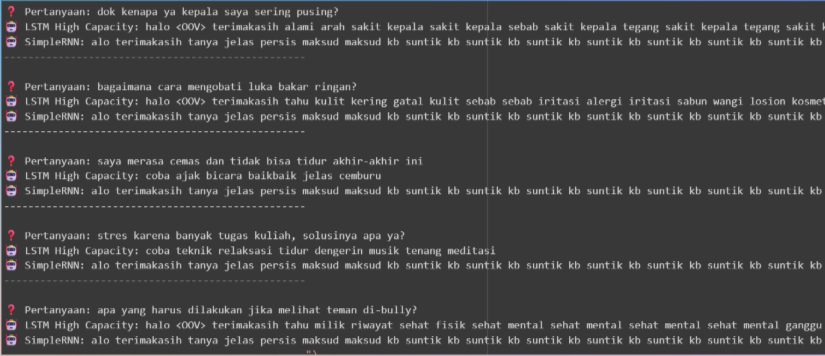

#### analisis


- LSTM Jauh Lebih Unggul: Model LSTM secara kualitatif dan kuantitatif jauh lebih unggul daripada SimpleRNN. Ia mampu menghasilkan jawaban yang relevan dan terkadang sangat akurat, sementara SimpleRNN gagal total.

- Bukti Kekuatan Arsitektur LSTM: Keberhasilan LSTM terletak pada arsitektur gates-nya (input, forget, output gate). Gates ini memungkinkan model untuk secara cerdas mengelola "memori"-nya, menyimpan informasi penting dari pertanyaan (seperti "stres" dan "solusi") dan membuang yang tidak relevan. Inilah yang mencegahnya dari mode collapse seperti yang dialami SimpleRNN.

- Keterbatasan Model LSTM: Meskipun unggul, model LSTM masih menunjukkan keterbatasan, seperti repetisi dan kesalahan dalam memahami konteks. Ini menunjukkan bahwa meskipun modelnya belajar, ia masih membutuhkan lebih banyak data, arsitektur yang lebih canggih (seperti Attention atau Transformer), atau tuning lebih lanjut untuk menjadi chatbot yang benar-benar andal.

## **Lanjutan 1, pre-trained embedding**

Menggunakan pre-trained word embeddings

### Unduh Vektor FastText untuk Bahasa Indonesia

In [61]:
# Unduh file pre-trained vectors dari situs resmi FastText
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz

# Ekstrak file .gz
!gunzip cc.id.300.vec.gz

print("\n✅ File vektor FastText untuk Bahasa Indonesia berhasil diunduh dan diekstrak.")

--2025-10-14 10:09:25--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.118.30, 99.84.118.60, 99.84.118.67, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.118.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1227018698 (1.1G) [binary/octet-stream]
Saving to: ‘cc.id.300.vec.gz’

cc.id.300.vec.gz    100%[===================>]   1.14G   160MB/s    in 14s     

2025-10-14 10:09:40 (82.9 MB/s) - ‘cc.id.300.vec.gz’ saved [1227018698/1227018698]

^C

✅ File vektor FastText untuk Bahasa Indonesia berhasil diunduh dan diekstrak.


### Muat Vektor ke Dalam Memori

In [131]:
import numpy as np
from tqdm import tqdm

embeddings_index = {}
# File yang sudah diekstrak bernama cc.id.300.vec
with open('cc.id.300.vec', 'r', encoding='utf-8') as f:
    # Baris pertama adalah metadata (jumlah kata dan dimensi), jadi kita lewati
    f.readline()
    # Kita gunakan tqdm untuk melihat progress bar
    for line in tqdm(f, desc="Memuat Vektor FastText"):
        values = line.split()
        word = values[0]
        try:
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
        except ValueError:
            # Lewati baris yang mungkin korup atau tidak sesuai format
            continue

print(f"\n✅ Berhasil memuat {len(embeddings_index)} vektor kata.")
# Dimensi embedding dari FastText adalah 300
embedding_dim_fasttext = 300

Memuat Vektor FastText: 2000000it [02:35, 12829.67it/s]


✅ Berhasil memuat 2000000 vektor kata.


### Buat Embedding Matrix

In [132]:
# Ambil word_index dari tokenizer chatbot yang sudah kita buat
word_index = tokenizer_qna.word_index
vocab_size_qna = 15000 # Pastikan ini sama dengan saat Anda membuat tokenizer

# Siapkan matriks embedding, diisi dengan nol
embedding_matrix = np.zeros((vocab_size_qna, embedding_dim_fasttext))

# Isi matriks dengan vektor dari FastText
# Loop melalui `vocab_size` kata teratas di tokenizer kita
for word, i in word_index.items():
    if i >= vocab_size_qna:
        continue # Abaikan kata yang di luar vocabulary size kita

    # Cari vektor kata di dalam dictionary FastText
    embedding_vector = embeddings_index.get(word)

    if embedding_vector is not None:
        # Jika kata ditemukan, masukkan vektornya ke dalam matriks
        embedding_matrix[i] = embedding_vector

print("✅ Embedding matrix berhasil dibuat.")

✅ Embedding matrix berhasil dibuat.


### Bangun dan train ulang best model awal dengan Pre-trained Embeddings

#### Build

In [133]:
# --- MEMBANGUN MODEL DENGAN PRE-TRAINED EMBEDDING ---

latent_dim = 256 # Gunakan arsitektur terbaik Anda (High Capacity)

# --- Encoder ---
encoder_inputs = Input(shape=(maxlen_question,))

embedding_layer = Embedding(
    input_dim=vocab_size_qna,
    output_dim=embedding_dim_fasttext, # Dimensi sekarang 300
    weights=[embedding_matrix], # Suntikkan matriks pre-trained di sini
    input_length=maxlen_question,
    trainable=False # "Bekukan" layer ini, kita tidak ingin mengubah pemahaman kata yg sudah kaya
)
encoder_embedding = embedding_layer(encoder_inputs)

encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# --- Decoder ---
decoder_inputs = Input(shape=(maxlen_answer,))
# Decoder juga menggunakan embedding layer yang sama
decoder_embedding = embedding_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

decoder_dense = Dense(vocab_size_qna, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model_chatbot_pretrained = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_chatbot_pretrained.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_chatbot_pretrained.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_42      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_50        │ (None, 50, 300)   │  4,500,000 │ input_layer_42[0… │
│ (Embedding)         │                   │            │ input_layer_43[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ [(None, 256),     │    570,368 │ embedding_50[0][… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ [(None, 50, 256), │    570,368 │ embedding_50[1][… │
│                     │ (None, 256),      │            │ lstm_24[0][1],    │
│                     │ (None, 256)]      │            │ lstm_24[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 50, 15000) │  3,855,000 │ lstm_25[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,495,736 (36.22 MB)

 Trainable params: 4,995,736 (19.06 MB)

 Non-trainable params: 4,500,000 (17.17 MB)

### train

In [ ]:
# --- Latih Model Baru ---
print("\n--- Melatih Model Chatbot dengan Pre-trained Embeddings ---")
num_epochs = 30
batch_size = 64
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_pretrained = model_chatbot_pretrained.fit(
    [X_train_qna, y_train_qna], y_train_target_qna,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

print("\n Training dengan Pre-trained Embeddings Selesai!")

### simpan model

In [139]:
model_terbaik = model_chatbot_pretrained

# Tentukan path lengkap beserta nama file di Google Drive
save_path = os.path.join(DATA_DIR, 'chatbot_pre-train_embedding.keras')

# Simpan model
model_terbaik.save(save_path)

print(f"✅ Model terbaik berhasil disimpan di: {save_path}")

✅ Model terbaik berhasil disimpan di: /content/drive/MyDrive/nlp-deepL/chatbot_pre-train_embedding.keras


### evaluate

In [136]:
print("--- Memulai Evaluasi Kuantitatif (Model Pre-trained) ---")

# Lakukan evaluasi pada data uji untuk model baru Anda
# Pastikan nama variabel modelnya benar (misal: model_chatbot_pretrained)
results_pretrained = model_chatbot_pretrained.evaluate(
    [X_test_qna, y_test_qna], y_test_target_qna,
    batch_size=64,
    verbose=0
)

print(f"Hasil Model BARU (Pre-trained) -> Loss: {results_pretrained[0]:.4f}, Accuracy: {results_pretrained[1]:.4f}")

# Tampilkan kembali hasil model terbaik sebelumnya untuk perbandingan langsung
# (Angka ini diambil dari hasil evaluasi Anda sebelumnya)
print(f"Hasil Model LAMA (High Capacity) -> Loss: 3.7067, Accuracy: 0.3473")

--- Memulai Evaluasi Kuantitatif (Model Pre-trained) ---
Hasil Model BARU (Pre-trained) -> Loss: 3.7447, Accuracy: 0.3391
Hasil Model LAMA (High Capacity) -> Loss: 3.7067, Accuracy: 0.3473


In [137]:
# Pilih model terbaik sebelumnya dan model baru
model_terbaik_lama = models_chatbot['LSTM High Capacity']
model_baru = model_chatbot_pretrained

# Siapkan beberapa pertanyaan yang sama seperti sebelumnya
test_questions = [
    "dok kenapa ya kepala saya sering pusing?",
    "bagaimana cara mengobati luka bakar ringan?",
    "saya merasa cemas dan tidak bisa tidur akhir-akhir ini",
    "stres karena banyak tugas kuliah, solusinya apa ya?",
    "apa yang harus dilakukan jika melihat teman di-bully?"
]

print("\n--- Memulai Uji Coba Kualitatif Berdampingan ---")

for question in test_questions:
    print(f"❓ Pertanyaan Pengguna: {question}")

    # Hasilkan jawaban dari model lama
    response_lama = generate_response(question, model_terbaik_lama)
    print(f"🤖 Jawaban LAMA (High Capacity): {response_lama}")

    # Hasilkan jawaban dari model baru dengan pre-trained embeddings
    response_baru = generate_response(question, model_baru)
    print(f"🚀 Jawaban BARU (Pre-trained): {response_baru}")

    print("-" * 50 + "\n")


--- Memulai Uji Coba Kualitatif Berdampingan ---
❓ Pertanyaan Pengguna: dok kenapa ya kepala saya sering pusing?
🤖 Jawaban LAMA (High Capacity): halo <OOV> terimakasih alami arah sakit kepala sakit kepala sebab sakit kepala tegang sakit kepala tegang sakit kepala cluster headache sakit kepala tegang sakit kepala cluster headache sakit kepala cluster sakit kepala sekunder sakit kepala sekunder sakit kepala sekunder sakit kepala sekunder sebab sakit kepala tegang sakit kepala cluster
🚀 Jawaban BARU (Pre-trained): halo <OOV> terimakasih alodoktercom keluh alami sebab ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas
--------------------------------------------------

❓ Pertanyaan Pengguna: bagaimana cara mengobati luka bakar ringan?
🤖 Jawaban LAMA (High Capacity): halo

In [138]:
# Pilih model yang ingin Anda ajak "ngobrol"
# Ganti dengan variabel model terbaik Anda, misalnya: model_chatbot_pretrained
model_untuk_chat = model_chatbot_pretrained

print("🤖 Chatbot Siap! Ketik 'exit' atau 'keluar' untuk berhenti.")
print("-" * 50)

while True:
    # 1. Minta input dari pengguna
    user_question = input("Anda: ")

    # 2. Kondisi untuk keluar dari loop
    if user_question.lower() in ["exit", "keluar"]:
        print("🤖 Senang bisa membantu! Sampai jumpa.")
        break

    # 3. Hasilkan respon menggunakan fungsi yang sudah ada
    bot_response = generate_response(user_question, model_untuk_chat)

    # 4. Tampilkan respon chatbot
    print(f"Chatbot: {bot_response}")
    print("-" * 20)

🤖 Chatbot Siap! Ketik 'exit' atau 'keluar' untuk berhenti.
--------------------------------------------------
Anda: hai
Chatbot: kayak kirim email chat biar baca mikir
--------------------
Anda: aku lagi stress
Chatbot: coba fokus tugas desak
--------------------
Anda: mata aku kelilipan
Chatbot: halo <OOV> terimakasih alodoktercom mata minus silinder mata minus silinder astigmatisme lensa silinder astigmatisme lensa silinder lensa kontak lensa kontak lensa kontak lensa kontak lensa kontak lensa kontak lensa kontak lensa kontak lensa kontak lensa kontak lensa kontak lensa kontak lensa kontak lensa kontak lensa kontak lensa kontak lensa
--------------------
Anda: kemaren aku tidur jam 3
Chatbot: alo terimakasih tanya jelas persis maksud obat sebut obat golong obat keras guna resep dokter obat obat guna resep dokter obat obat guna resep dokter obat obat guna resep dokter obat obat guna resep dokter obat obat guna resep dokter obat obat guna resep dokter obat obat guna resep
-------------

**Temuan**: LSTM dengan pre-trained embedding secara kualitatif  lebih rendah daripada LSTM sebelumnya. tetapi, Ia mampu menghasilkan jawaban yang terkadang lebih relevan.

## **Lanjutan 2, hanya pakai satu dataset**

### Load & preprocess

In [141]:
df_psychiatry_only = df_qna_combined[df_qna_combined['sumber'] == 'psikiater'].copy()

# Reset index agar rapi
df_psychiatry_only.reset_index(drop=True, inplace=True)

print(f"✅ Berhasil mengisolasi data psikiater.")
print(f"Total data yang akan digunakan: {len(df_psychiatry_only)} baris.")
display(df_psychiatry_only.head())

✅ Berhasil mengisolasi data psikiater.
Total data yang akan digunakan: 6477 baris.


,question,answer,sumber,question_clean,answer_clean,answer_processed
0,"Oke, gue coba lebih santai deh.",Bagus. Semangat terus ya. Kamu pasti bisa ngel...,psikiater,oke gue coba santai deh,bagus semangat ngelewatin,<start> bagus semangat ngelewatin <end>
1,"Iya sih, tapi kalo gak gitu rasanya gak beres-...",Coba kasih jeda buat istirahat. Otak juga butu...,psikiater,iya sih kalo gak gak beresberes,coba kasih jeda istirahat otak butuh refreshing,<start> coba kasih jeda istirahat otak butuh r...
2,"Thanks ya, Dok. Gue coba buat lebih santai.",Bagus. Jangan lupa jaga kesehatan juga.,psikiater,thanks dok gue coba santai,bagus lupa jaga sehat,<start> bagus lupa jaga sehat <end>
3,Gue belum pernah coba meditasi.,Banyak aplikasi atau video di YouTube yang bis...,psikiater,gue coba meditasi,aplikasi video youtube bantu meditasi coba deh,<start> aplikasi video youtube bantu meditasi ...
4,"Ortu gue lagi susah, jadi malu minta bantuan k...",Ngerti perasaan lo. Tapi gimana kalau lo coba ...,psikiater,ortu gue susah malu bantu,ngerti asa coba cari bantu kayak kampus,<start> ngerti asa coba cari bantu kayak kampu...


In [142]:
# --- 1. MEMPERSIAPKAN DATA TEKS ---
df_psychiatry_only['answer_processed'] = df_psychiatry_only['answer_clean'].apply(lambda x: '<start> ' + str(x) + ' <end>')
questions_psychiatry = df_psychiatry_only['question_clean'].astype(str).values
answers_psychiatry = df_psychiatry_only['answer_processed'].astype(str).values

# --- 2. BUAT TOKENIZER BARU ---
# Kosakatanya lebih kecil karena datanya lebih sedikit
vocab_size_psychiatry = 5000
oov_token = "<OOV>"

# Inisialisasi dan fit tokenizer HANYA pada data psikiater
tokenizer_psychiatry = Tokenizer(num_words=vocab_size_psychiatry, oov_token=oov_token, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer_psychiatry.fit_on_texts(np.append(questions_psychiatry, answers_psychiatry))

# Ubah teks menjadi sequences
question_sequences_psychiatry = tokenizer_psychiatry.texts_to_sequences(questions_psychiatry)
answer_sequences_psychiatry = tokenizer_psychiatry.texts_to_sequences(answers_psychiatry)

# --- 3. PADDING SEQUENCES ---
# Kita bisa gunakan maxlen yang sama atau menyesuaikannya
maxlen_question = 50
maxlen_answer = 50

encoder_input_data_psychiatry = pad_sequences(question_sequences_psychiatry, maxlen=maxlen_question, padding='post', truncating='post')
decoder_input_data_psychiatry = pad_sequences(answer_sequences_psychiatry, maxlen=maxlen_answer, padding='post', truncating='post')

# --- 4. PERSIAPAN TARGET DECODER ---
decoder_target_data_psychiatry = np.zeros_like(decoder_input_data_psychiatry)
for i, seq in enumerate(decoder_input_data_psychiatry):
    decoder_target_data_psychiatry[i, :-1] = seq[1:]

# --- 5. DATA SPLITTING ---
X_train_psychiatry, X_test_psychiatry, y_train_psychiatry, y_test_psychiatry = train_test_split(
    encoder_input_data_psychiatry, decoder_input_data_psychiatry, test_size=0.2, random_state=42
)
y_train_target_psychiatry, y_test_target_psychiatry = train_test_split(
    decoder_target_data_psychiatry, test_size=0.2, random_state=42
)

print("\n✅ Data psikiater berhasil dipersiapkan untuk model.")
print(f"Bentuk data latih (X_train): {X_train_psychiatry.shape}")


✅ Data psikiater berhasil dipersiapkan untuk model.
Bentuk data latih (X_train): (5181, 50)


### Train

In [ ]:
# --- MEMBANGUN MODEL (Arsitektur High Capacity) ---
latent_dim = 256
embedding_dim = 128

# Encoder
encoder_inputs = Input(shape=(maxlen_question,))
encoder_embedding = Embedding(input_dim=vocab_size_psychiatry, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(maxlen_answer,))
decoder_embedding_layer = Embedding(input_dim=vocab_size_psychiatry, output_dim=embedding_dim)
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_psychiatry, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model_chatbot_specialist = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_chatbot_specialist.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_chatbot_specialist.summary()

# --- MELATIH MODEL SPESIALIS ---
print("\n--- Melatih Model Chatbot Spesialis Psikiatri ---")
num_epochs = 50 # Kita beri epoch lebih banyak karena risiko overfitting lebih tinggi
batch_size = 32 # Batch size lebih kecil untuk dataset kecil
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_specialist = model_chatbot_specialist.fit(
    [X_train_psychiatry, y_train_psychiatry], y_train_target_psychiatry,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

print("\n✅ Training Model Spesialis Selesai!")

### Evaluate

#### Quantitative

In [144]:
print("--- Memulai Evaluasi Kuantitatif (Model Spesialis Psikiatri) ---")

# Lakukan evaluasi pada data uji psikiatri
results_specialist = model_chatbot_specialist.evaluate(
    [X_test_psychiatry, y_test_psychiatry], y_test_target_psychiatry,
    batch_size=64,
    verbose=0
)

print(f"Hasil Model BARU (Spesialis Psikiatri) -> Loss: {results_specialist[0]:.4f}, Accuracy: {results_specialist[1]:.4f}\n")

print("--- Sebagai Referensi (TIDAK BISA DIBANDINGKAN LANGSUNG) ---")
print(f"Hasil Model LAMA (Pre-trained 50k) -> Loss: 3.7447, Accuracy: 0.3391")

--- Memulai Evaluasi Kuantitatif (Model Spesialis Psikiatri) ---
Hasil Model BARU (Spesialis Psikiatri) -> Loss: 0.3421, Accuracy: 0.9453

--- Sebagai Referensi (TIDAK BISA DIBANDINGKAN LANGSUNG) ---
Hasil Model LAMA (Pre-trained 50k) -> Loss: 3.7447, Accuracy: 0.3391


Perbandingan kuantitatif ini hanya menunjukkan bahwa setiap model berkinerja baik di dalam lingkungannya sendiri, sehingga tidak bisa dibandingkan

#### Qualitative

In [147]:
# Buat dictionary pemetaan indeks ke kata untuk tokenizer BARU
reverse_word_index_specialist = {v: k for k, v in tokenizer_psychiatry.word_index.items()}

# Fungsi generate_response yang disesuaikan untuk model spesialis
def generate_response_specialist(input_text, model):
    clean_text = preprocess_text_cached(input_text)
    input_seq = tokenizer_psychiatry.texts_to_sequences([clean_text]) # Gunakan tokenizer_psychiatry
    encoder_input = pad_sequences(input_seq, maxlen=maxlen_question, padding='post', truncating='post')

    start_token_index = tokenizer_psychiatry.word_index.get('<start>', 1)
    decoder_input = np.zeros((1, maxlen_answer))
    decoder_input[0, 0] = start_token_index

    generated_sentence = []
    for i in range(1, maxlen_answer):
        predictions = model.predict([encoder_input, decoder_input], verbose=0)
        predicted_id = np.argmax(predictions[0, i-1, :])

        if predicted_id == tokenizer_psychiatry.word_index.get('<end>', 2) or predicted_id == 0:
            break

        word = reverse_word_index_specialist.get(predicted_id, '<UNK>') # Gunakan reverse_word_index_specialist
        generated_sentence.append(word)
        decoder_input[0, i] = predicted_id

    return ' '.join(generated_sentence)

In [148]:
# Pilih model generalis (pre-trained) dan model spesialis yang baru
model_generalis = model_chatbot_pretrained
model_spesialis = model_chatbot_specialist

# Siapkan beberapa pertanyaan psikiatri untuk diuji
test_questions = [
    "saya merasa cemas dan tidak bisa tidur akhir-akhir ini",
    "stres karena banyak tugas kuliah, solusinya apa ya?",
    "gimana cara menghadapi teman yang toxic?",
    "rasanya hampa dan tidak punya motivasi, harus gimana?",
    # Tambahkan satu pertanyaan medis untuk melihat bagaimana spesialis gagal
    "bagaimana cara mengobati luka bakar ringan?"
]

print("\n--- Memulai Uji Coba Kualitatif: Generalis vs. Spesialis ---")

for question in test_questions:
    print(f"❓ Pertanyaan Pengguna: {question}")

    # Hasilkan jawaban dari model generalis
    # (Menggunakan fungsi generate_response yang lama)
    response_generalis = generate_response(question, model_generalis)
    print(f"🤖 Jawaban Generalis (50k): {response_generalis}")

    # Hasilkan jawaban dari model spesialis
    # (Menggunakan fungsi generate_response_specialist yang baru)
    response_spesialis = generate_response_specialist(question, model_spesialis)
    print(f"🧑‍⚕️ Jawaban Spesialis (6k): {response_spesialis}")

    print("-" * 50 + "\n")


--- Memulai Uji Coba Kualitatif: Generalis vs. Spesialis ---
❓ Pertanyaan Pengguna: saya merasa cemas dan tidak bisa tidur akhir-akhir ini
🤖 Jawaban Generalis (50k): coba cari teman ajak ngobrol santai
🧑‍⚕️ Jawaban Spesialis (6k): coba ajak dosen diskusi nilai baik
--------------------------------------------------

❓ Pertanyaan Pengguna: stres karena banyak tugas kuliah, solusinya apa ya?
🤖 Jawaban Generalis (50k): coba jadwal hari prioritas
🧑‍⚕️ Jawaban Spesialis (6k): mungkin coba nyampein asa
--------------------------------------------------

❓ Pertanyaan Pengguna: gimana cara menghadapi teman yang toxic?
🤖 Jawaban Generalis (50k): alo terimakasih tanya jelas persis warna kuning hijau hijau kandung warna kuning hijau kuning hijau kuning hijau kuning hijau kuning hijau kuning hijau kuning hijau kuning hijau kuning hijau kuning hijau kuning hijau kuning hijau kuning hijau kuning hijau kuning hijau kuning hijau kuning hijau kuning hijau kuning hijau
🧑‍⚕️ Jawaban Spesialis (6k): oke 

**Temuan:** Untuk menghasilkan jawaban yang koheren, dataset yang lebih kecil tetapi berkualitas tinggi dan konsisten terbukti lebih unggul daripada dataset besar yang "berisik" (noisy).

## **Lanjutan, pembersihan pattern sapaan data medis**

### cleaning

menghapus semua variasi sapaan pembuka (halo, terima kasih, nama, dll.)

In [162]:
import re
import pandas as pd

# Asumsikan 'df_qna_combined' adalah DataFrame 50k Anda
print("Memulai pembersihan final (paling efektif) pada jawaban medis...")

# 1. Definisikan pola regex yang sangat efektif untuk sapaan + nama
# Pola ini mencari sapaan, lalu menghapus 1 hingga 4 kata berikutnya (dianggap sebagai nama)
# \b[a-zA-Z]+\b memastikan kita hanya mencocokkan kata utuh.
pattern_greeting_and_name = re.compile(
    r'^(?:halo|hallo|helo|hello|hai|alo|dear|salam|selamat|waalaikumsalam|waalaikumsallam (?:pagi|siang|sore|malam))\s+(?:\b[a-zA-Z]+\b\s*){1,4}',
    re.IGNORECASE
)

# 2. Definisikan pola untuk sisa-sisa template yang mungkin tertinggal
pattern_leftover_template = re.compile(
    r'^(terima kasih|terimakasih|alodokter)\s*(?:atas pertanyaannya|di alodokter|alodoktercom)?\s*[:,]?',
    re.IGNORECASE
)

# 3. Buat kolom baru untuk jawaban yang sudah dibersihkan
df_qna_combined['answer_final_clean'] = df_qna_combined['answer_clean']

# Dapatkan indeks dari baris medis
medical_indices = df_qna_combined[df_qna_combined['sumber'] == 'medis'].index

# 4. Terapkan pembersihan secara BERURUTAN HANYA pada data medis
# Terapkan pola utama (sapaan + nama)
df_qna_combined.loc[medical_indices, 'answer_final_clean'] = df_qna_combined.loc[medical_indices, 'answer_final_clean'].str.replace(pattern_greeting_and_name, '', regex=True)
# Terapkan pola pembersihan sisa template
df_qna_combined.loc[medical_indices, 'answer_final_clean'] = df_qna_combined.loc[medical_indices, 'answer_final_clean'].str.replace(pattern_leftover_template, '', regex=True)
df_qna_combined.loc[medical_indices, 'answer_final_clean'] = df_qna_combined.loc[medical_indices, 'answer_final_clean'].str.replace(pattern_leftover_template, '', regex=True)
df_qna_combined.loc[medical_indices, 'answer_final_clean'] = df_qna_combined.loc[medical_indices, 'answer_final_clean'].str.replace(pattern_leftover_template, '', regex=True)

# Terakhir, rapikan spasi di awal kalimat
df_qna_combined.loc[medical_indices, 'answer_final_clean'] = df_qna_combined.loc[medical_indices, 'answer_final_clean'].str.strip()

print("✅ Pembersihan final selesai.")

# 5. Tampilkan perbandingan untuk verifikasi
print("\n--- Perbandingan Sebelum dan Sesudah Pembersihan Final ---")
# Kita ambil sampel yang lebih banyak untuk melihat variasi
display(df_qna_combined[df_qna_combined['sumber'] == 'medis'][['answer_clean', 'answer_final_clean']].sample(20))

Memulai pembersihan final (paling efektif) pada jawaban medis...
✅ Pembersihan final selesai.

--- Perbandingan Sebelum dan Sesudah Pembersihan Final ---


,answer_clean,answer_final_clean
19723,halo sabil sesak nafas serta nafas bunyi ngik ...,nafas bunyi ngik grok nafas sesak sesak nafas ...
24576,halo siti amalia benjol payudara timbul khawat...,timbul khawatir derita benjol payudara gejala ...
11903,hai tandatanda awal hamil mudah nali lambat me...,nali lambat menstruasi menstruasi menstruasi l...
27846,salam alodokter terima kasih alodokter keluh s...,keluh sakit perut kanan mual muntah susah nafa...
11897,terima kasih alodoktercom bintik ruam merah ku...,bintik ruam merah kulit milik sebab serta peri...
45050,terima kasih adytama tanya beda dokter tim alo...,adytama tanya beda dokter tim alodokter sebab ...
23278,alo selamat pagi laku operasi memang evaluasi ...,memang evaluasi rumah sakit ada baik maka dokt...
9203,alo syamsul arifin terimakasih alodokter kenal...,kenal drrio jawab sini hasil lab lengkap darah...
24000,dear nhea haid kunjung maksud mungkin haid dap...,mungkin haid dapat hingga haid menarche menarc...
20941,hai midamida nyeri alami menstruasi akibat kon...,akibat kontraksi otot rahim lebih endometriosi...


### prepare data

In [163]:
# --- 1. GUNAKAN TEKS YANG SUDAH DIBERSIHKAN ---
# Penting: Gunakan kolom 'answer_final_clean' yang baru
df_qna_combined['answer_processed_final'] = df_qna_combined['answer_final_clean'].apply(lambda x: '<start> ' + str(x) + ' <end>')

questions_final = df_qna_combined['question_clean'].astype(str).values
answers_final = df_qna_combined['answer_processed_final'].astype(str).values

# --- 2. BUAT SEQUENCES BARU MENGGUNAKAN TOKENIZER LAMA ---
# Kita tidak perlu membuat tokenizer baru, cukup gunakan yang sudah ada (`tokenizer_qna`)
question_sequences_final = tokenizer_qna.texts_to_sequences(questions_final)
answer_sequences_final = tokenizer_qna.texts_to_sequences(answers_final)

# --- 3. PADDING SEQUENCES ---
maxlen_question = 50
maxlen_answer = 50

encoder_input_data_final = pad_sequences(question_sequences_final, maxlen=maxlen_question, padding='post', truncating='post')
decoder_input_data_final = pad_sequences(answer_sequences_final, maxlen=maxlen_answer, padding='post', truncating='post')

# --- 4. PERSIAPAN TARGET DECODER BARU ---
decoder_target_data_final = np.zeros_like(decoder_input_data_final)
for i, seq in enumerate(decoder_input_data_final):
    decoder_target_data_final[i, :-1] = seq[1:]

# --- 5. DATA SPLITTING BARU ---
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    encoder_input_data_final, decoder_input_data_final, test_size=0.2, random_state=42
)
y_train_target_final, y_test_target_final = train_test_split(
    decoder_target_data_final, test_size=0.2, random_state=42
)

print("\n✅ Data yang telah dibersihkan sepenuhnya siap untuk dilatih!")
print(f"Bentuk data latih (X_train_final): {X_train_final.shape}")


✅ Data yang telah dibersihkan sepenuhnya siap untuk dilatih!
Bentuk data latih (X_train_final): (40000, 50)


### train

In [165]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

# --- Parameter Model ---
# Pastikan parameter ini sesuai dengan data yang sudah Anda siapkan
embedding_dim = 128
latent_dim = 128  # Ukuran state untuk satu arah LSTM (total akan menjadi 256)
vocab_size_qna = 15000
maxlen_question = 50
maxlen_answer = 50

# --- 1. ENCODER (Dengan Bi-directional LSTM) ---
encoder_inputs = Input(shape=(maxlen_question,), name='encoder_input')

encoder_embedding_layer = Embedding(
    input_dim=vocab_size_qna,
    output_dim=embedding_dim,
    name='encoder_embedding'
)
encoder_embedding = encoder_embedding_layer(encoder_inputs)

# INILAH PERUBAHAN UTAMA: LSTM dibungkus dengan Bidirectional
encoder_lstm = Bidirectional(
    LSTM(latent_dim, return_state=True, name='encoder_lstm')
)
# Layer Bidirectional akan mengembalikan 5 output:
# output gabungan, state_h maju, state_c maju, state_h mundur, state_c mundur
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)

# Kita gabungkan state dari kedua arah untuk menjadi "vektor pikiran" final
state_h_final = Concatenate(name='concatenate_h')([forward_h, backward_h])
state_c_final = Concatenate(name='concatenate_c')([forward_c, backward_c])
encoder_states = [state_h_final, state_c_final]


# --- 2. DECODER (Harus disesuaikan untuk menerima state yang lebih besar) ---
decoder_inputs = Input(shape=(maxlen_answer,), name='decoder_input')

# Decoder menggunakan embedding layer yang sama untuk efisiensi
decoder_embedding = encoder_embedding_layer(decoder_inputs)

# karena ia menerima state gabungan dari arah maju dan mundur
decoder_lstm = LSTM(
    latent_dim * 2, # Ukurannya harus 256 untuk cocok dengan state_h_final dan state_c_final
    return_sequences=True,
    return_state=True,
    name='decoder_lstm'
)
# Decoder diinisialisasi dengan state final dari encoder
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Lapisan output tetap sama
decoder_dense = Dense(vocab_size_qna, activation='softmax', name='output_dense')
decoder_outputs = decoder_dense(decoder_outputs)


# --- 3. GABUNGKAN MENJADI MODEL FINAL ---
model_chatbot_bidirectional = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# --- 4. KOMPILASI MODEL ---
model_chatbot_bidirectional.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model Chatbot dengan Bi-directional Encoder berhasil dibuat.")
model_chatbot_bidirectional.summary()

✅ Model Chatbot dengan Bi-directional Encoder berhasil dibuat.


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_input       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 50, 128)   │  1,920,000 │ encoder_input[0]… │
│ (Embedding)         │                   │            │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 256),     │    263,168 │ encoder_embeddin… │
│ (Bidirectional)     │ (None, 128),      │            │                   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_h       │ (None, 256)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_c       │ (None, 256)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 50, 256), │    394,240 │ encoder_embeddin… │
│                     │ (None, 256),      │            │ concatenate_h[0]… │
│                     │ (None, 256)]      │            │ concatenate_c[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 50, 15000) │  3,855,000 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,432,408 (24.54 MB)

 Trainable params: 6,432,408 (24.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\n--- Melatih Model Chatbot dengan Bi-directional Encoder ---")

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Gunakan data yang sudah bersih sepenuhnya (final)
history_bidirectional = model_chatbot_bidirectional.fit(
    [X_train_final, y_train_final], y_train_target_final,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping], # Gunakan EarlyStopping yang sudah ada
    verbose=1
)

print("\n✅ Training model Bi-directional selesai!")

### evaluate

In [167]:
print("--- Memulai Evaluasi Kuantitatif (Model Bi-directional) ---")

# Lakukan evaluasi pada data uji untuk model baru Anda
# Pastikan nama variabel modelnya benar (model_chatbot_bidirectional)
results_bidirectional = model_chatbot_bidirectional.evaluate(
    [X_test_final, y_test_final], y_test_target_final,
    batch_size=64,
    verbose=0
)

print(f"Hasil Model BARU (Bi-directional) -> Loss: {results_bidirectional[0]:.4f}, Accuracy: {results_bidirectional[1]:.4f}")

# Tampilkan kembali hasil model terbaik sebelumnya untuk perbandingan langsung
print(f"Hasil Model LAMA (High Capacity)  -> Loss: 3.7067, Accuracy: 0.3473")

--- Memulai Evaluasi Kuantitatif (Model Bi-directional) ---
Hasil Model BARU (Bi-directional) -> Loss: 3.8630, Accuracy: 0.3276
Hasil Model LAMA (High Capacity)  -> Loss: 3.7067, Accuracy: 0.3473


In [169]:
# Pilih model terbaik sebelumnya dan model baru
model_terbaik_lama = model_chatbot_pretrained
model_baru_bidirectional = model_chatbot_bidirectional

# Siapkan pertanyaan yang sama untuk perbandingan yang adil
test_questions = [
    "dok kenapa ya kepala saya sering pusing?",
    "bagaimana cara mengobati luka bakar ringan?",
    "saya merasa cemas dan tidak bisa tidur akhir-akhir ini",
    "stres karena banyak tugas kuliah, solusinya apa ya?",
    "apa yang harus dilakukan jika melihat teman di-bully?"
]

print("\n--- Memulai Uji Coba Kualitatif: LSTM High Capacity vs. Bi-directional ---")

for question in test_questions:
    print(f"❓ Pertanyaan Pengguna: {question}")

    # Hasilkan jawaban dari model lama
    response_lama = generate_response(question, model_terbaik_lama)
    print(f"🤖 Jawaban LAMA (High Capacity): {response_lama}")

    # Hasilkan jawaban dari model baru dengan Bi-directional Encoder
    response_baru = generate_response(question, model_baru_bidirectional)
    print(f"🚀 Jawaban BARU (Bi-directional): {response_baru}")

    print("-" * 50 + "\n")


--- Memulai Uji Coba Kualitatif: LSTM High Capacity vs. Bi-directional ---
❓ Pertanyaan Pengguna: dok kenapa ya kepala saya sering pusing?
🤖 Jawaban LAMA (High Capacity): halo <OOV> terimakasih alodoktercom keluh alami sebab ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas
🚀 Jawaban BARU (Bi-directional): pusing pusing pusing pusing putar vertigo vertigo sebab vertigo vertigo sebab vertigo sebab vertigo vertigo sebab vertigo sebab vertigo sebab vertigo vertigo sebab vertigo sebab vertigo sebab vertigo sebab vertigo vertigo sebab vertigo sebab vertigo sebab vertigo vertigo sebab vertigo sebab vertigo sebab vertigo vertigo sebab vertigo sebab vertigo
--------------------------------------------------

❓ Pertanyaan Pengguna: bagaimana cara mengobati luka bakar ringan?

**Temuan:** meskipun skornya lebih rendah, secara konsisten menghasilkan jawaban yang lebih relevan, spesifik, dan bernuansa pada topik yang kompleks.

Ini membuktikan bahwa pemahaman konteks dua arah sangat efektif untuk tugas percakapan.

## **Test live chat**

### load model

In [26]:
from tensorflow.keras.models import load_model
import os

# 1. Definisikan kembali path folder Anda di Google Drive
DATA_DIR = '/content/drive/MyDrive/nlp-deepL'

# 2. Tentukan nama file model yang ingin Anda muat
model1 = 'chatbot_LSTM_best.keras'
model2 = 'chatbot_pre-train_embedding.keras'
model_sentimen = 'sentimen_rnn_terbaik.keras'

# 3. Buat path lengkap ke file model
path_lengkap_model1 = os.path.join(DATA_DIR, model1)
path_lengkap_model2 = os.path.join(DATA_DIR, model2)
path_lengkap_model3 = os.path.join(DATA_DIR, model_sentimen)

try:
    # 4. Muat model menggunakan load_model()
    model_LSTM = load_model(path_lengkap_model1)
    print(f" Model '{model1}' berhasil dimuat dari Google Drive!")

    model_embedding = load_model(path_lengkap_model2)
    print(f" Model '{model2}' berhasil dimuat dari Google Drive!")

    model_rnn_sentimen = load_model(path_lengkap_model3)
    print(f" Model '{model_sentimen}' berhasil dimuat dari Google Drive!")

    # 5. Verifikasi model dengan menampilkan summary-nya
    print("\nBerikut adalah arsitektur dari model yang dimuat:")
    model_LSTM.summary()
    model_embedding.summary()
    model_sentimen.summary()

except FileNotFoundError:
    print(f"❌ ERROR: File model tidak ditemukan '")
    print("Pastikan nama file dan path folder sudah benar.")
except Exception as e:
    print(f"❌ Terjadi error saat memuat model: {e}")

 Model 'chatbot_LSTM_best.keras' berhasil dimuat dari Google Drive!
 Model 'chatbot_pre-train_embedding.keras' berhasil dimuat dari Google Drive!
 Model 'sentimen_rnn_terbaik.keras' berhasil dimuat dari Google Drive!

Berikut adalah arsitektur dari model yang dimuat:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 50, 128)   │  1,920,000 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 50, 128)   │  1,920,000 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ [(None, 256),     │    394,240 │ embedding_12[0][… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ [(None, 50, 256), │    394,240 │ embedding_13[0][… │
│                     │ (None, 256),      │            │ lstm_9[0][1],     │
│                     │ (None, 256)]      │            │ lstm_9[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 50, 15000) │  3,855,000 │ lstm_10[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,450,442 (97.09 MB)

 Trainable params: 8,483,480 (32.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,966,962 (64.72 MB)

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_42      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_50        │ (None, 50, 300)   │  4,500,000 │ input_layer_42[0… │
│ (Embedding)         │                   │            │ input_layer_43[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ [(None, 256),     │    570,368 │ embedding_50[0][… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ [(None, 50, 256), │    570,368 │ embedding_50[1][… │
│                     │ (None, 256),      │            │ lstm_24[0][1],    │
│                     │ (None, 256)]      │            │ lstm_24[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 50, 15000) │  3,855,000 │ lstm_25[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,487,210 (74.34 MB)

 Trainable params: 4,995,736 (19.06 MB)

 Non-trainable params: 4,500,000 (17.17 MB)

 Optimizer params: 9,991,474 (38.11 MB)

❌ Terjadi error saat memuat model: 'str' object has no attribute 'summary'


### chatbot


In [21]:
# Pilih model yang ingin Anda ajak "ngobrol"
# Ganti dengan variabel model terbaik Anda, misalnya: model_chatbot_pretrained
model_untuk_chat = model_LSTM

print("🤖 Chatbot Siap! Ketik 'exit' atau 'keluar' untuk berhenti.")
print("-" * 50)

while True:
    # 1. Minta input dari pengguna
    user_question = input("Anda: ")

    # 2. Kondisi untuk keluar dari loop
    if user_question.lower() in ["exit", "keluar"]:
        print("🤖 Senang bisa membantu! Sampai jumpa.")
        break

    # 3. Hasilkan respon menggunakan fungsi yang sudah ada
    bot_response = generate_response(user_question, model_untuk_chat)

    # 4. Tampilkan respon chatbot
    print(f"Chatbot: {bot_response}")
    print("-" * 20)

🤖 Chatbot Siap! Ketik 'exit' atau 'keluar' untuk berhenti.
--------------------------------------------------
Anda: exit
🤖 Senang bisa membantu! Sampai jumpa.


In [20]:
# Pilih model yang ingin Anda ajak "ngobrol"
# Ganti dengan variabel model terbaik Anda, misalnya: model_chatbot_pretrained
model_untuk_chat = model_embedding

print("🤖 Chatbot Siap! Ketik 'exit' atau 'keluar' untuk berhenti.")
print("-" * 50)

while True:
    # 1. Minta input dari pengguna
    user_question = input("Anda: ")

    # 2. Kondisi untuk keluar dari loop
    if user_question.lower() in ["exit", "keluar"]:
        print("🤖 Senang bisa membantu! Sampai jumpa.")
        break

    # 3. Hasilkan respon menggunakan fungsi yang sudah ada
    bot_response = generate_response(user_question, model_untuk_chat)

    # 4. Tampilkan respon chatbot
    print(f"Chatbot: {bot_response}")
    print("-" * 20)

🤖 Chatbot Siap! Ketik 'exit' atau 'keluar' untuk berhenti.
--------------------------------------------------
Anda: hai
Chatbot: kayak kirim email chat biar baca mikir
--------------------
Anda: jangan marah atuh
Chatbot: coba ajak bicara baikbaik
--------------------
Anda: kemaren aku stress gara gara banyak tugas
Chatbot: ingat istirahat bagi produktivitas capek gak efektif
--------------------
Anda: iya, kemaren aku juga kurang tidur
Chatbot: coba cari teman ajak ngobrol santai bahas akademik
--------------------
Anda: sekarang pusing, belum makan dari pagi
Chatbot: halo <OOV> terimakasih alodoktercom keluh utara sebab ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas ganggu cemas
--------------------
Anda: aku belum makan dari pagi
Chatbot: alo terimakasih tanya jelas persis 

In [24]:
# Pilih model-model yang akan diuji
model_lama = model_LSTM
model_baru = model_embedding

# Siapkan set pertanyaan final yang paling komprehensif
test_questions_final = [
    # --- Medis: Interaksi & Kondisi Spesifik ---
    "setelah makan seafood saya gatal-gatal, apakah ini alergi?",
    "apa bedanya pusing karena vertigo dan pusing karena darah rendah?",
    "anak saya demam tinggi dan tidak mau makan, harus bagaimana?",
    "benarkah minum es bisa menyebabkan batuk?",

    # --- Psikiatri: Skenario & Perasaan Kompleks ---
    "saya merasa gagal karena teman-teman saya sudah sukses.",
    "bagaimana cara membangun kembali kepercayaan setelah dibohongi?",
    "apakah normal merasa sedih tanpa alasan yang jelas?",
    "saya sulit fokus saat bekerja dan sering melamun, apa solusinya?",

    # --- Pertanyaan Menjebak & Logika Sederhana ---
    "apakah lebih baik mencegah atau mengobati?",
    "jika saya minum obat tidur, apakah saya akan bangun lagi?",

    # --- Out-of-Domain: Topik Spesifik & Teknis ---
    "jelaskan proses fotosintesis secara sederhana.",
    "bagaimana cara kerja internet?"
]


for question in test_questions_final:
    print(f"❓ Pertanyaan Pengguna: {question}")

    # Hasilkan jawaban dari model lama
    response_lama = generate_response(question, model_lama)
    print(f"🤖 LSTM: {response_lama}")

    # Hasilkan jawaban dari model baru dengan Bi-directional Encoder
    response_baru = generate_response(question, model_baru)
    print(f"🚀 Embedding: {response_baru}")

    print("-" * 50 + "\n")

❓ Pertanyaan Pengguna: setelah makan seafood saya gatal-gatal, apakah ini alergi?
🤖 LSTM: halo <OOV> terimakasih tanya alodokter gatal kulit sebab alergi iritasi akibat bahan kimia zat kimia zat kimia zat kimia zat kimia zat kimia zat kimia dalam tubuh zat zat zat zat zat zat zat zat zat zat zat dalam tubuh zat zat zat dalam tubuh zat zat zat zat
🚀 Embedding: alo terimakasih tanya produk sebut kandung bahan aktif kandung zat aktif kandung zat aktif dalam tubuh zat aktif dalam tubuh zat aktif dalam tubuh zat aktif dalam tubuh zat zat zat kandung zat aktif zat zat zat zat zat zat zat zat zat zat zat zat zat zat zat
--------------------------------------------------

❓ Pertanyaan Pengguna: apa bedanya pusing karena vertigo dan pusing karena darah rendah?
🤖 LSTM: alo terimakasih tanya pusing pusing putar pusing putar pusing putar vertigo pusing putar vertigo pusing putar vertigo pusing putar vertigo pusing putar vertigo vertigo vertigo vertigo vertigo perifer vertigo sentral vertigo perife

## **Kesimpulan Akhir**

Pemenang:
LSTM (dan variannya)

Temuan:
LSTM secara kuantitatif dan kualitatif jauh mengungguli SimpleRNN. SimpleRNN mengalami mode collapse, sementara LSTM mampu menghasilkan jawaban yang relevan dan terstruktur

Kesimpulan:
Untuk tugas yang membutuhkan pemahaman konteks dan memori jangka panjang, arsitektur gate pada LSTM terbukti sangat krusial dan superior.

### **Kualitas Data > Kuantitas & Arsitektur**

**Pentingnya Kualitas Data (Eksperimen "Spesialis Psikiatri")**

Temuan: Model yang dilatih pada 6.000 data psikiatri yang berkualitas menghasilkan jawaban yang lebih koheren dan tidak repetitif dibandingkan model yang dilatih pada 50.000 data campuran yang "noisy" dengan pola template.

Kesimpulan: Kualitas dan konsistensi data lebih penting daripada jumlahnya untuk menghasilkan chatbot yang andal. Prinsip "Garbage In, Garbage Out" terbukti benar.

**Pentingnya Arsitektur Canggih (Eksperimen "Bi-directional")**

Temuan: Model Bi-directional LSTM, meskipun memiliki skor kuantitatif yang sedikit lebih rendah, secara konsisten menghasilkan jawaban yang paling cerdas, spesifik, dan relevan secara kontekstual pada evaluasi kualitatif.

Kesimpulan: Untuk pemahaman nuansa percakapan, arsitektur yang lebih canggih yang dapat memahami konteks secara penuh (Bi-directional) memberikan keunggulan performa yang nyata.

## **perbaiki stemming**

In [63]:
display(df_qna_combined.head())

,question,answer,sumber,question_clean,answer_clean,answer_processed
0,"Malam dok, awalnya saya merasa tidak merasakan...","Alo, terima kasih sudah bertanya kepada Alodok...",medis,malam dok rasa apaapa tibatiba tubuh hilang im...,alo terima kasih alodokter erti khawatir keluh...,<start> alo terima kasih alodokter erti khawat...
1,"Alo Dok, bagaimana untuk bisa mengetahui kalau...",Terima kasih atas pertanyaannya. Infeksi pada ...,medis,alo dok kena helicobacter pylori obat periksa ...,terima kasih tanya infeksi lambung sebab bakte...,<start> terima kasih tanya infeksi lambung seb...
2,"Selamat siang dok, saya memiliki bayi berusia ...","Alo Jantia, Terimakasih atas pertanyaannya. B...",medis,selamat siang dok milik bayi usia bayi alami b...,alo jantia terimakasih tanya bruntusan serta m...,<start> alo jantia terimakasih tanya bruntusan...
3,"Siang Dok, maaf tanya\r 1. Apakah hidrokel pad...",Halo Aji Hidrokel berbeda dengan hernia. Hidr...,medis,siang dok maaf hidrokel dewasa th bahaya rasa ...,halo aji hidrokel beda hernia hidrokel tumpu c...,<start> halo aji hidrokel beda hernia hidrokel...
4,dok saya mau tanya tentang dampak dan gejala a...,"Alo Glourythaa Lekatompessy, terimakasih sudah...",medis,dok dampak gejala kepala injak bagi kepala rak...,alo glourythaa lekatompessy terimakasih alodok...,<start> alo glourythaa lekatompessy terimakasi...


In [80]:
print("Memulai preprocessing pada data Q&A (chatbot)...")

df_qna_cleaned = df_qna_combined

# Lakukan preprocessing hanya pada sampel ini
df_qna_cleaned['question_clean'] = df_qna_cleaned['question'].progress_apply(preprocess_text_cached)
df_qna_cleaned['answer_clean'] = df_qna_cleaned['answer'].progress_apply(preprocess_text_cached)

print("\n Preprocessing data Q&A selesai.")
print("Berikut perbandingan teks asli dan teks bersih untuk Q&A:")

# Gabungkan path folder dengan nama file untuk membuat path lengkap
save_path_qna = os.path.join(DATA_DIR, 'qna_50k_clean_part2.feather')\

# Simpan file ke path yang sudah ditentukan di Google Drive
df_qna_combined.to_feather(save_path_qna)

print(f"File Q&A berhasil disimpan di: {save_path_qna}")
# Tampilkan kolom asli dan kolom yang sudah bersih untuk perbandingan
display(df_qna_cleaned[['question', 'question_clean', 'answer', 'answer_clean']].sample(10))

Memulai preprocessing pada data Q&A (chatbot)...


  1%|          | 295/50000 [00:02<06:28, 128.10it/s]


KeyboardInterrupt: 